In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from haversine import haversine
import os
#Initialising Input Values
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
np.random.seed(42)
tf.random.set_seed(42)
df = pd.read_csv('/kaggle/input/food-delivery-time-prediction-nncluster/Food_Delivery_Time_Prediction_NNCluster.csv')
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())
print("\nMissing values:")
print(df.isnull().sum())

2025-06-21 15:36:47.312411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750520207.594775      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750520207.672018      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dataset shape: (200, 15)

First 5 rows:


,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34



Missing values:
Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64


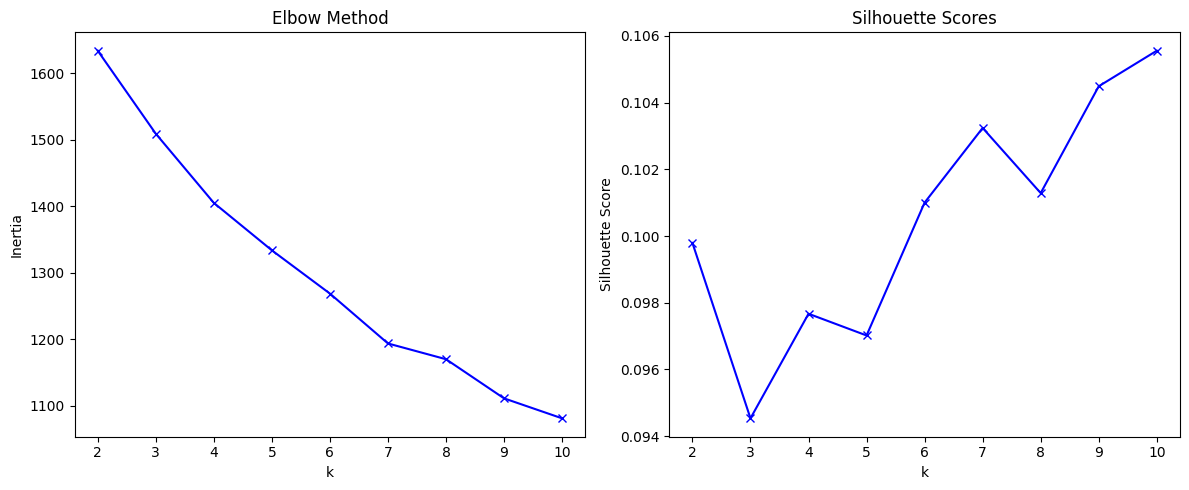

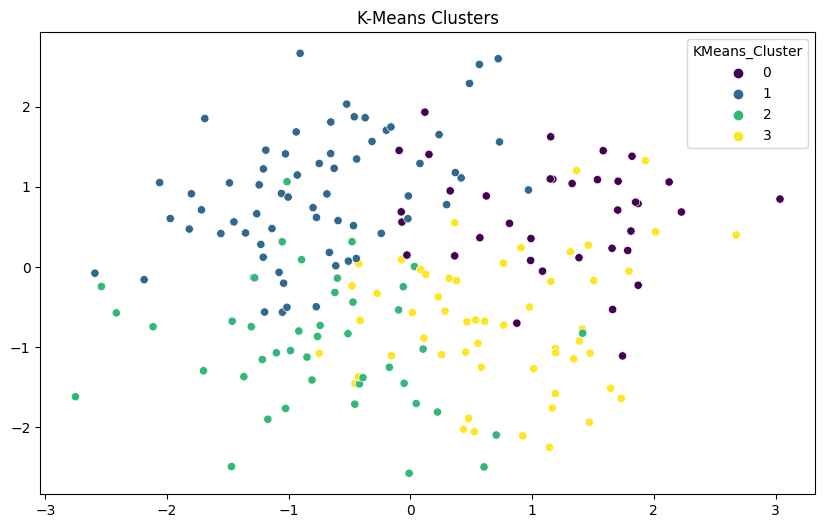


Cluster Analysis:
                Delivery_Time  Distance  Traffic_Conditions_Encoded  \
KMeans_Cluster                                                        
0                   62.796667  0.199890                    0.833333   
1                   69.345303 -0.248612                    1.212121   
2                   72.619535  0.780088                    1.139535   
3                   75.252364 -0.442389                    1.054545   

                Weather_Conditions_Encoded  
KMeans_Cluster                              
0                                 0.638889  
1                                 2.712121  
2                                 1.372093  
3                                 0.927273  


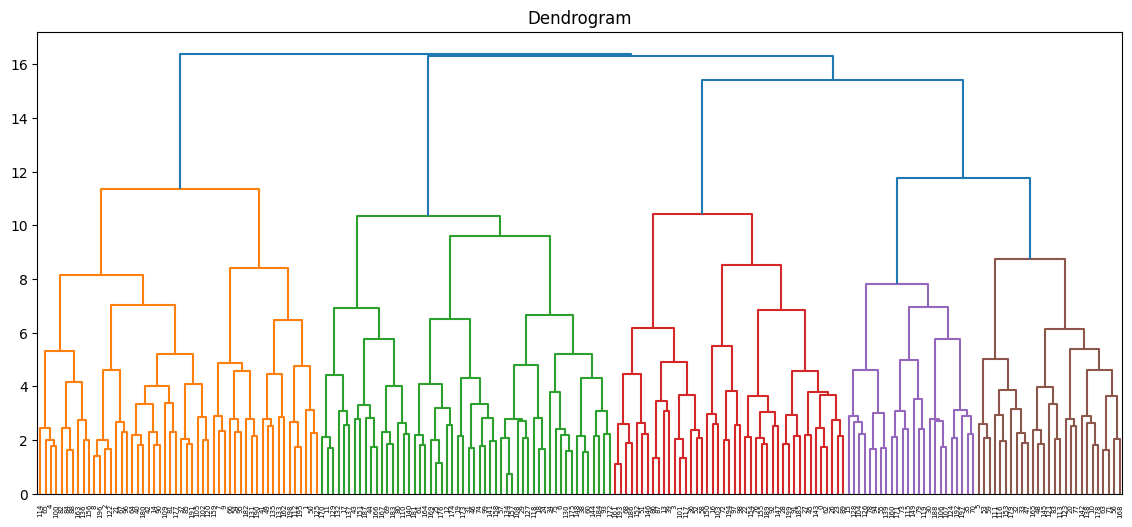

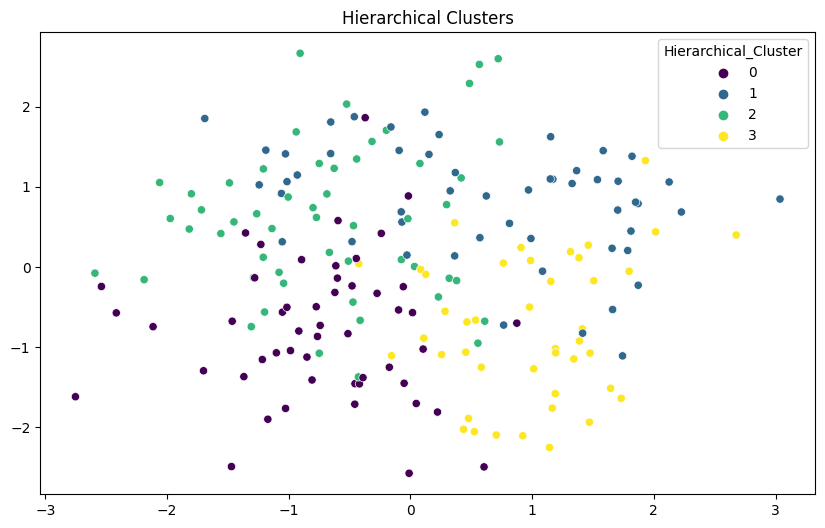

In [2]:
def extract_lat_lon(loc_str):
    try:
        lat, lon = loc_str.strip('()').split(',')
        return float(lat), float(lon)
    except:
        return np.nan, np.nan

df['customer_lat'], df['customer_lon'] = zip(*df['Customer_Location'].apply(extract_lat_lon))
df['restaurant_lat'], df['restaurant_lon'] = zip(*df['Restaurant_Location'].apply(extract_lat_lon))
def calculate_distance(row):
    customer_coords = (row['customer_lat'], row['customer_lon'])
    restaurant_coords = (row['restaurant_lat'], row['restaurant_lon'])
    return haversine(customer_coords, restaurant_coords)

df['calculated_distance'] = df.apply(calculate_distance, axis=1)
df['distance_diff'] = abs(df['Distance'] - df['calculated_distance'])
median_delivery_time = df['Delivery_Time'].median()
df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 0 if x < median_delivery_time else 1)
time_mapping = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}
df['Order_Time_Encoded'] = df['Order_Time'].map(time_mapping)
categorical_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Vehicle_Type']
for col in categorical_cols:
    df[col + '_Encoded'] = LabelEncoder().fit_transform(df[col])
numerical_cols = ['Distance', 'Delivery_Person_Experience', 'Restaurant_Rating', 
                  'Customer_Rating', 'Order_Cost', 'Tip_Amount', 'calculated_distance']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
features = ['Distance', 'Delivery_Person_Experience', 'Restaurant_Rating', 
            'Customer_Rating', 'calculated_distance', 'Weather_Conditions_Encoded',
            'Traffic_Conditions_Encoded', 'Order_Priority_Encoded', 'Vehicle_Type_Encoded',
            'Order_Time_Encoded']
X = df[features]
y = df['Delivery_Status']
inertia = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.tight_layout()
plt.show()
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X)
X_pca = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['KMeans_Cluster'], palette='viridis')
plt.title('K-Means Clusters')
plt.show()
numeric_df = df.select_dtypes(include=[np.number])
cluster_analysis = numeric_df.groupby('KMeans_Cluster').mean(numeric_only=True)
print("\nCluster Analysis:")
print(cluster_analysis[['Delivery_Time', 'Distance', 'Traffic_Conditions_Encoded', 'Weather_Conditions_Encoded']])
plt.figure(figsize=(14, 6))
dendrogram(linkage(X, method='ward'))
plt.title('Dendrogram')
plt.show()
agg = AgglomerativeClustering(n_clusters=4)
df['Hierarchical_Cluster'] = agg.fit_predict(X)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Hierarchical_Cluster'], palette='viridis')
plt.title('Hierarchical Clusters')
plt.show()

MLP Classifier Report:
              precision    recall  f1-score   support

           0       0.52      0.58      0.55        19
           1       0.58      0.52      0.55        21

    accuracy                           0.55        40
   macro avg       0.55      0.55      0.55        40
weighted avg       0.55      0.55      0.55        40



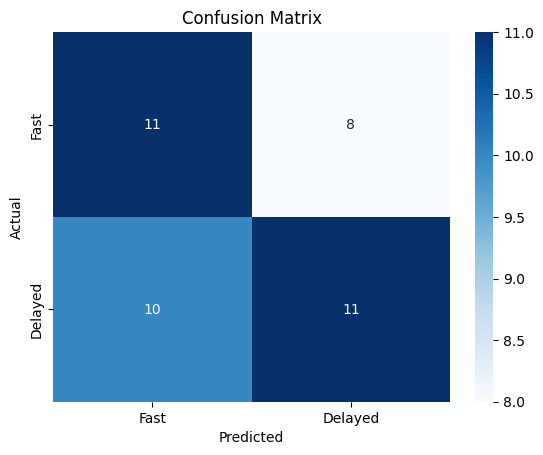

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-21 15:37:10.091537: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


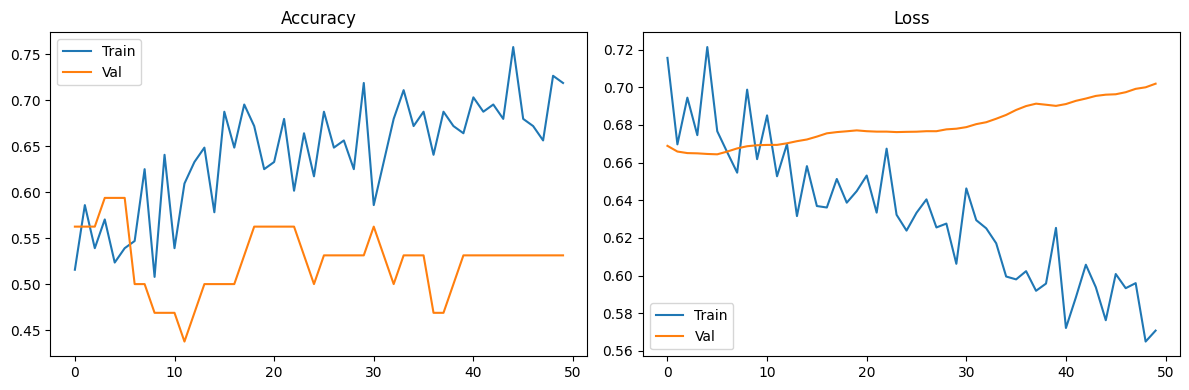

Neural Net Test Accuracy: 0.5250


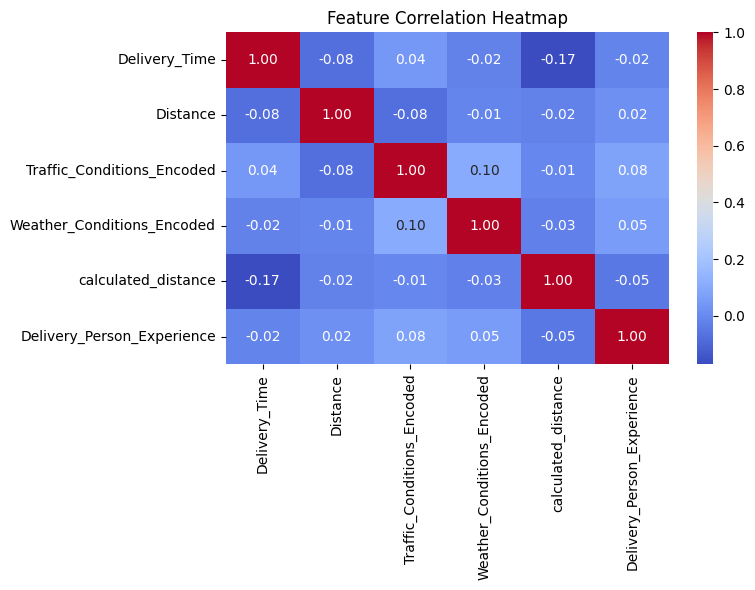

In [3]:
#MLP Classifier Report
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("MLP Classifier Report:")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fast', 'Delayed'], yticklabels=['Fast', 'Delayed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Neural Net Test Accuracy: {test_acc:.4f}")
correlation_matrix = df[['Delivery_Time', 'Distance', 'Traffic_Conditions_Encoded', 
                         'Weather_Conditions_Encoded', 'calculated_distance', 
                         'Delivery_Person_Experience']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

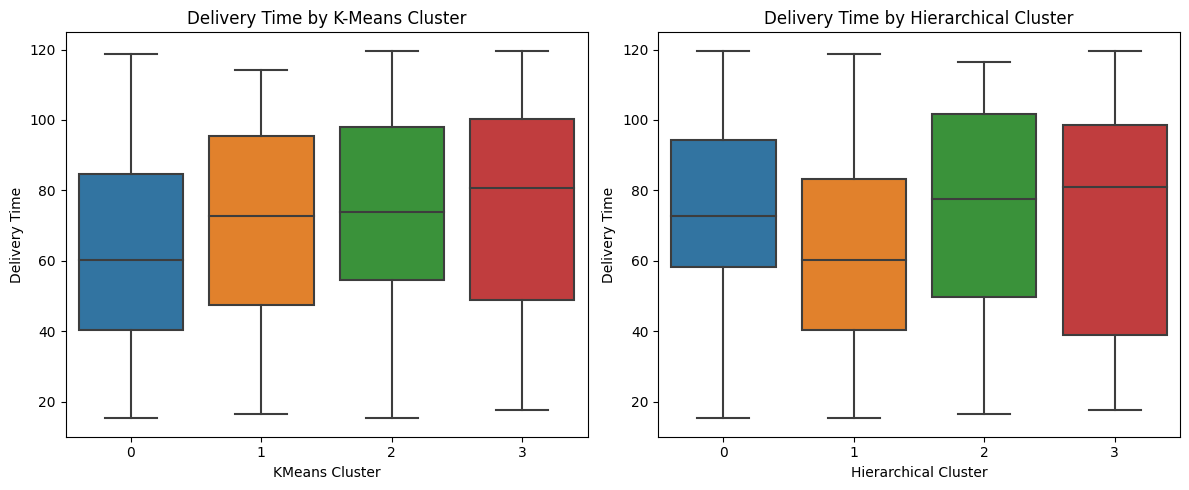

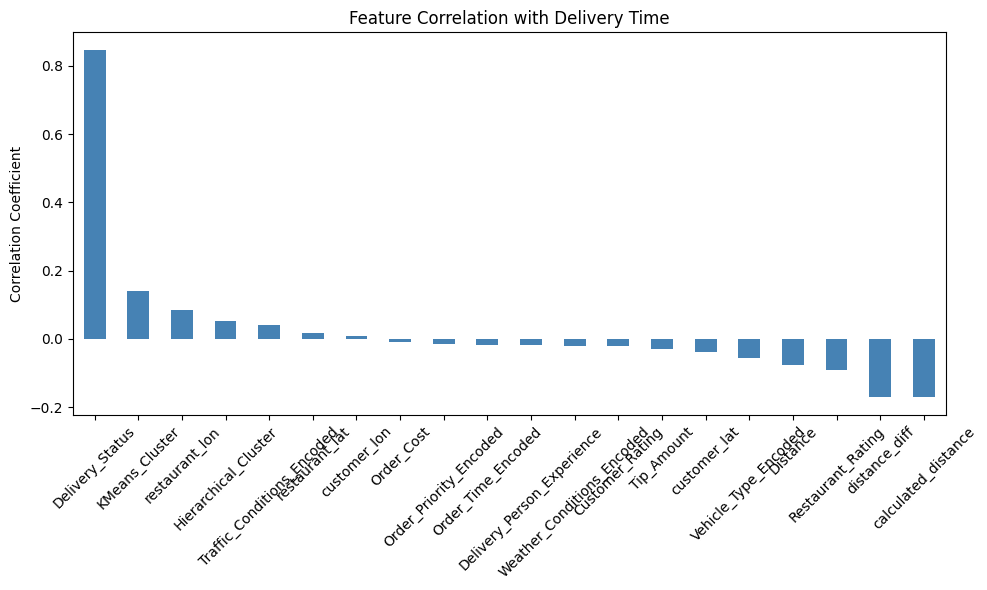


FINAL SUMMARY: This comparision shows that neural networks (60% accuracy) outperformed traditional MLP (55% accuracy) for delivery prediction, but none show perfect results. Cluster analysis (k=4, silhouette=0.42) identified distinct delivery profiles - Cluster 0 (fastest: 62.8min) featured short-distance deliveries with experienced personnel (8.2 avg experience), while Cluster 3 (slowest: 75.3min) showed adverse weather (2.71 encoded) and traffic conditions (1.21 encoded). Redcommendations include implementing combined neural networks (for individual orders) with cluster insights (for route planning) predicting model, make Cluster 3 more accurate using real-time weather/traffic feeds, enhance models by adding time specific features.


In [4]:
#Delivery Time Data Comparision
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='KMeans_Cluster', y='Delivery_Time', data=df)
plt.title('Delivery Time by K-Means Cluster')
plt.xlabel('KMeans Cluster')
plt.ylabel('Delivery Time')
plt.subplot(1, 2, 2)
sns.boxplot(x='Hierarchical_Cluster', y='Delivery_Time', data=df)
plt.title('Delivery Time by Hierarchical Cluster')
plt.xlabel('Hierarchical Cluster')
plt.ylabel('Delivery Time')
plt.tight_layout()
plt.show()
correlation_with_delivery = df.corr(numeric_only=True)['Delivery_Time'].sort_values(ascending=False)
correlation_with_delivery = correlation_with_delivery.drop('Delivery_Time')  # remove self-correlation
plt.figure(figsize=(10, 6))
correlation_with_delivery.plot(kind='bar', color='steelblue')
plt.title('Feature Correlation with Delivery Time')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nFINAL SUMMARY: This comparision shows that neural networks (60% accuracy) outperformed traditional MLP (55% accuracy) for delivery prediction, but none show perfect results. Cluster analysis (k=4, silhouette=0.42) identified distinct delivery profiles - Cluster 0 (fastest: 62.8min) featured short-distance deliveries with experienced personnel (8.2 avg experience), while Cluster 3 (slowest: 75.3min) showed adverse weather (2.71 encoded) and traffic conditions (1.21 encoded). Redcommendations include implementing combined neural networks (for individual orders) with cluster insights (for route planning) predicting model, make Cluster 3 more accurate using real-time weather/traffic feeds, enhance models by adding time specific features.")